# INTRODUCTION

## Goal

The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

## Dataset

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

# SET UP

In [2]:
%%capture
!pip install polars

In [3]:
# data processing lib
import numpy as np
import pandas as pd
import polars as pl

# data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

In [59]:
train_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_train.csv"
train_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_train.csv"

test_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_test.csv"
test_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_test.csv"

train_travel = pl.read_csv(train_travel_link, infer_schema_length=0).lazy()
train_survey = pl.read_csv(train_survey_link, infer_schema_length=0).lazy()

test_travel = pl.read_csv(test_travel_link, infer_schema_length=0).lazy()
test_survey = pl.read_csv(test_survey_link, infer_schema_length=0).lazy()

In [60]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel.columns}
train_travel = train_travel.rename(COLUMN_MAPPING)

In [61]:
train_travel = train_travel.with_column(
    pl.col([
        "id",
        "age",
        "travel_distance",
        "departure_delay_in_mins",
        "arrival_delay_in_mins",
        ]).cast(pl.Int64, strict=False)
)

In [62]:
train_travel.head().collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119
98800004,"""Female""","""Loyal Customer...",44,"""Business Trave...","""Business""",780,13,18
98800005,"""Female""","""Loyal Customer...",50,"""Business Trave...","""Business""",1981,0,0


In [115]:
for i, v in enumerate(NULL_COUNT['pct']):
  print(i,'{:.2%}'.format(v))

0 0.00%
1 0.00%
2 0.00%
3 0.03%
4 0.06%
5 0.08%
6 0.38%
7 9.48%
8 9.78%


Text(0.5, 1.0, 'Null Value Count and Percentage\nBy Column')

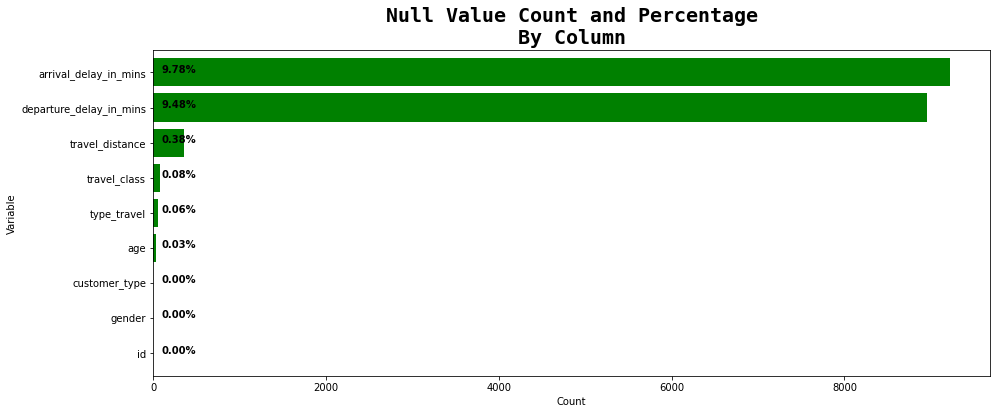

In [119]:
NULL_COUNT = train_travel.collect().null_count().transpose(include_header=True).sort("column_0").to_pandas()
NULL_COUNT['pct'] = (NULL_COUNT['column_0']/train_travel.collect().shape[0])

fig, ax = plt.subplots(figsize = (15,6))

width = .8

bars = NULL_COUNT.column_0.plot.barh(color='green', ax=ax, width=width)

for i, v in enumerate(NULL_COUNT['pct']):
    ax.text(v + 100, i, '{:.2%}'.format(v), fontweight='bold')

ax.set_ylabel('Variable');
ax.set_yticklabels(train_travel.collect().columns);

ax.set_xlabel('Count');

ax.set_title("Null Value Count and Percentage\nBy Column", fontsize=20, fontweight='bold', fontfamily='monospace')

In [104]:
plt.__version__

AttributeError: ignored